# Cooke triplet example with ray aiming

I'm using this "textbook" example of a Cooke triplet, to see if I can do ray aiming. That's where you adjust the ray bundles from each field so they all cross over at the Stop surface.

https://wp.optics.arizona.edu/jsasian/wp-content/uploads/sites/33/2016/03/L20_OPTI517_Cooke_triplet.pdf

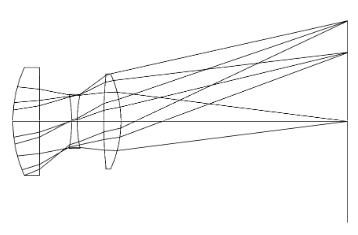

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import opticsRayTrace.rayTraceTools as rtt
import opticsRayTrace.drawing as rtd

This is just copy-pasted from the author's slide show. I added the "N" to the glasses myself.

In [2]:
s = '''1 STANDARD 23.713 4.831 N-LAK9
2 STANDARD 7331.288 5.86
STO STANDARD -24.456 0.975 N-SF5
4 STANDARD 21.896 4.822
5 STANDARD 86.759 3.127 N-LAK9
6 STANDARD -20.4942 41.10346'''

t = [u.split() for u in s.split('\n')]
t

[['1', 'STANDARD', '23.713', '4.831', 'N-LAK9'],
 ['2', 'STANDARD', '7331.288', '5.86'],
 ['STO', 'STANDARD', '-24.456', '0.975', 'N-SF5'],
 ['4', 'STANDARD', '21.896', '4.822'],
 ['5', 'STANDARD', '86.759', '3.127', 'N-LAK9'],
 ['6', 'STANDARD', '-20.4942', '41.10346']]

I wrote a crude script to turn the surface list into the format needed by my program

In [3]:
def s2surf(s):
    surf = {'surf': 'conic',
            'c': 1/float(s[2]),
            'k': 0,
            'dist': float(s[3]),
           'draw_radius': 10}
    if len(s) > 4:
        surf['material'] = s[4]
    return surf
    
surface_list = [{'surf': 'dummy', 'dist': -10}, {'surf': 'dummy', 'dist': 10}] + [s2surf(u) for u in t] + [{'surf': 'dummy'}]
stop_surface = 4
surface_list[stop_surface]['stop'] = True

This is a basic ray trace. I've added a pupil shift to my **new_ray_table()** function, which will allow ray aiming.

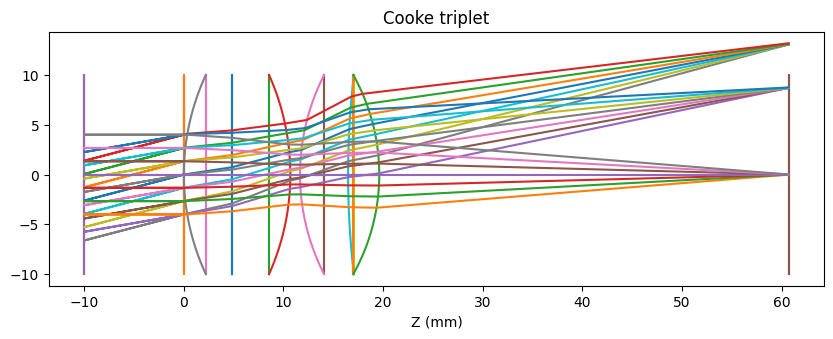

In [4]:
geometry = rtt.build_geometry(surface_list)

# Lists of field anles, pupil heights, and (for now) zero pupil shifts

lsf = np.array([15, 10, 0]) #np.linspace(-10, 10, 3)
lsp = np.linspace(-4, 4, 7)
lsps = np.array([0, 0, 0])

# turn those lists into rays

field_rays = np.array([np.array([x*np.pi/180, 0, 1]) for x in lsf])
pupil_points = np.array([np.array([x, 0, 0]) for x in lsp])
pupil_shifts = np.array([np.array([x, 0, 0]) for x in lsps])
wavls = np.array([0.000633])

# my usual ray tracing steps

ray_table = rtt.new_ray_table(geometry, field_rays, pupil_points, wavls, infinite = True,
                             pupil_shifts = pupil_shifts)
rtt.propagate_ray(ray_table, geometry)

# now let's see what we've got

axd = rtd.new_plot_xy(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, marker = '.', markersize = 3)
axd["axs"][0].set_title("Cooke triplet")
plt.show()

The apparent entrance pupil is at the entrance to the system, not where we want it. Now I need to choose values for the pupil shifts. I will say that the rays are correctly "aimed" when the ray bundle for each field angle is centered at the stop surface, i.e., that the squared position of those rays is at a minimum. This suggests a merit function and optimization.

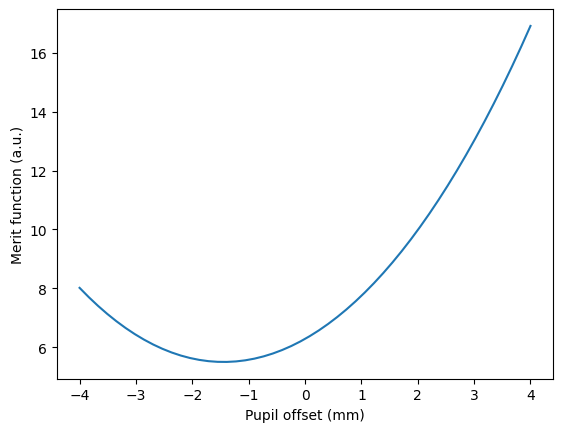

In [5]:
def merit_function(lsps):
    '''
    Merit function for ray aiming optimization, using lots of globals defined above
    
    lsps = list of pupil shifts
    '''
    
    # Convert pupil shifts into 3 dimensional points
    
    pupil_shifts = np.array([np.array([x, 0, 0]) for x in lsps])
    
    # Build a new ray table with those shifts, and trace the rays
    
    ray_table = rtt.new_ray_table(geometry, field_rays, pupil_points, wavls, infinite = True,
                             pupil_shifts = pupil_shifts)
    rtt.propagate_ray(ray_table, geometry)
    
    # Compute the merit function based on the squres of X positions
    
    merit = np.average(ray_table[stop_surface, :, 0, 0]**2)
    return merit

# Let's see if the merit function has a minimum and is well behaved

za = np.linspace(-4, 4)
plt.plot(za, [merit_function([z, 0, -z]) for z in za])
plt.xlabel('Pupil offset (mm)')
plt.ylabel('Merit function (a.u.)')
plt.show()

I've been having pretty good luck with the default minimization function from SciPy, so let's just try it, with starting values of zero.

In [6]:
m = minimize(merit_function, [0, 0, 0])
lsps_aimed = m['x']
lsps_aimed

array([-3.06161397e+00, -1.99538309e+00, -4.38102407e-09])

Now let's apply the new pupil shifts and trace the rays again

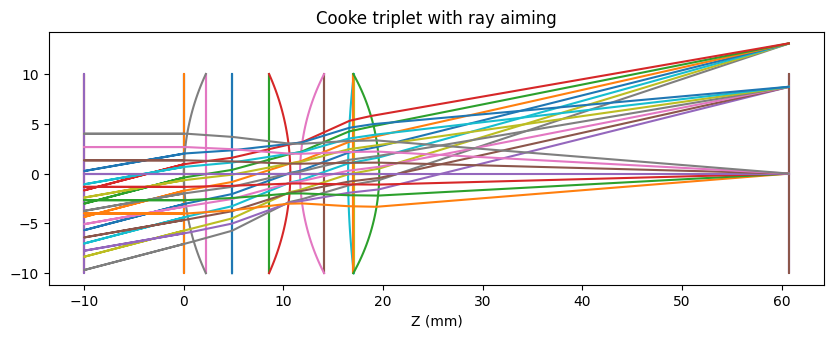

In [7]:
pupil_shifts = np.array([np.array([x, 0, 0]) for x in lsps_aimed])
ray_table = rtt.new_ray_table(geometry, field_rays, pupil_points, wavls, infinite = True,
                             pupil_shifts = pupil_shifts)
rtt.propagate_ray(ray_table, geometry)
axd = rtd.new_plot_xy(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, marker = '.', markersize = 3)
axd["axs"][0].set_title("Cooke triplet with ray aiming")
plt.show()

One last trimming: I didn't give any radii for drawing the surfaces, and it's hard to visually compare the drawings to the one from the reference, so I created a little script that applies a default to each surface, just big enough to contain the rays, plus a margin. This is purely aesthetic. My program doesn't do anything with the draw radius while ray tracing.

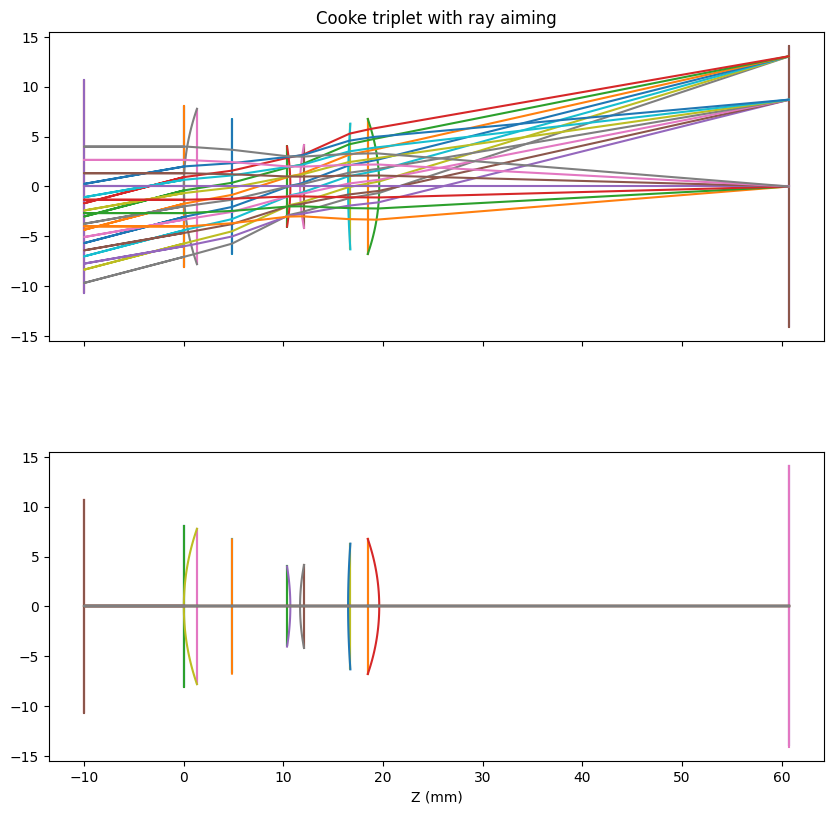

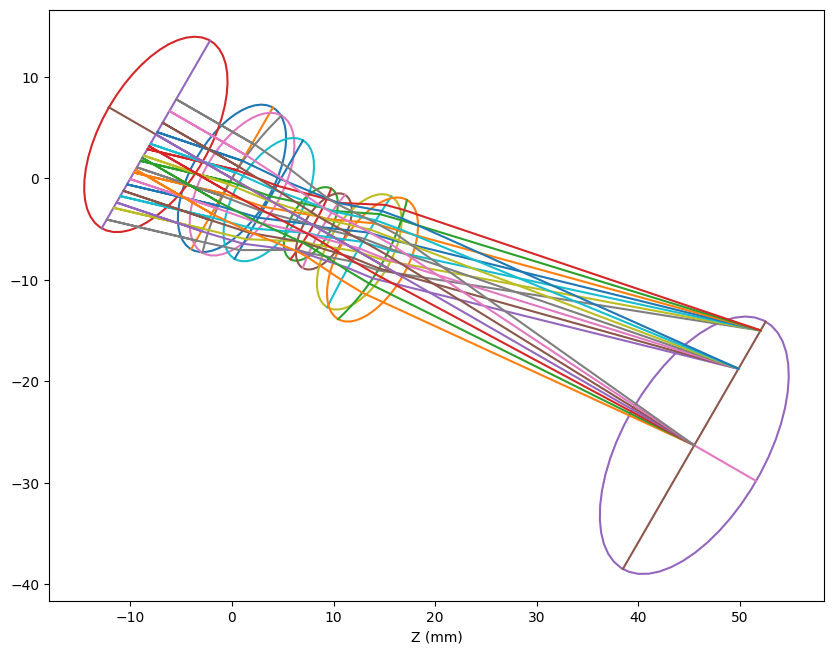

In [8]:
def find_draw_radii(ray_table):
    radius_list = []
    for surf in range(ray_table.shape[0]):
        radius = np.max(np.sqrt(np.sum(ray_table[surf, :, 0, :-1]**2, axis = 1)))
        radius_list.append(radius)
    return np.array(radius_list)

def apply_draw_radii(geometry, ray_table, margin):
    radii = find_draw_radii(ray_table) + margin
    for i in range(len(geometry)):
        geometry[i]['draw_radius'] = radii[i]
        
apply_draw_radii(geometry, ray_table, 1)
axd = rtd.new_plot_xy(axes = ["x", "y"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, marker = '.', markersize = 3)
axd["axs"][0].set_title("Cooke triplet with ray aiming")
plt.show()
axd = rtd.new_plot_xy(axes = ["3d"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, marker = '.', markersize = 3)